# Statement of the Problem

We want to solve the system of equations given by

$$
\phi''(y)-4\phi'(y)-\epsilon(\epsilon - 4)\phi(y) + \lambda h^2(y) = 0 \\ 
h''(y)-4 h'(y) - (m_h^2 - \lambda \phi(y))h(y) = 0
$$

with boundary conditions

$$
\phi(0) = v_0, \quad \phi(y_1) = v_1, \quad h'(0) = \frac{M_0^2}{2}h(0), \quad h'(y_1) = -\lambda_h h(y_1)\left( h^2(y_1) - \frac{v_h^2}{2}\right)
$$

We do get a numerically more tractable equation if we parametrize $h(y)$ as 

$$
h(y)=\tilde{h} e^{2(y-y_1)}f(y)
$$

In this parametrization, the differential equation for $f$ becomes

$$
f''(y) - (4 + m_h^2 -\lambda \phi(y))f(y) = 0
$$

with boundary conditions for $f$ become

$$
f'(0) = \left(\frac{M_0^2}{2}-2\right)f(0),\quad 2 + \frac{f'(y_1)}{f(y_1)}=-\lambda_h \left(\tilde{h}^2 f^2(y_1) - \frac{v_h^2}{2}\right)
$$

# Building the initial guess

In order to use `solve_bvp` we need to create an initial guess. We will do this as follows: First we do consider the differential equation for $\phi(y)$ by neglecting the $\lambda h^2(y)$ term. Then the differential equation can be exactly solved to give

$$
\phi_0(y) = \phi_{\epsilon} e^{\epsilon y} + \phi_4 e^{(4-\epsilon)y}
$$

where $\phi_{\epsilon}$ and $\phi_4$ are coefficients determined using the boundary conditions. We can easily find

$$
\phi_4 = v_0 - \phi_{\epsilon}\quad ,\phi_{\epsilon} = \frac{v_1 - v_0 e^{(4-\epsilon)y_1}}{e^{\epsilon y_1} - e^{(4-\epsilon)y_1}}
$$

Let's create the function which will return this solution.

In [1]:
## Looks like we need to work with the decimal module
from decimal import *

## We also need higher precision
getcontext().prec = 60

getcontext()

Context(prec=60, rounding=ROUND_HALF_EVEN, Emin=-999999, Emax=999999, capitals=1, clamp=0, flags=[], traps=[InvalidOperation, DivisionByZero, Overflow])

In [2]:
import numpy as np

param = []
param.append(Decimal('0.1')) # v0
param.append(Decimal('1')) # v1
param.append(Decimal('0.1')) # epsilon
param.append(Decimal('25951')/Decimal('1000'))# y1
param.append(Decimal('-349')/Decimal('90')) # mhsq
param.append(Decimal('2')/Decimal('9')) # lambda
param.append(Decimal('0.125')) # lambda_h
param.append(Decimal('4')) # m0sq
param.append(Decimal('-20')) # vhsq
param.append(Decimal('0.1')) # delta T

def GW0(y):
    yDec = Decimal(str(y))
    v0, v1, epsilon, y1 = param[:4]
    GWeps = (v1 - v0*np.exp((4 - epsilon)*y1))/(np.exp(epsilon*y1) - np.exp((4 - epsilon)*y1))
    GW4 = v0 - GWeps
    res = GWeps * np.exp(epsilon*yDec) + GW4 * np.exp((4 - epsilon)*yDec)
    return res.quantize(Decimal('0.000000000000001'), rounding=ROUND_DOWN)

def GW0Der(y):
    yDec = Decimal(str(y))
    v0, v1, epsilon, y1 = param[:4]
    GWeps = (v1 - v0*np.exp((4 - epsilon)*y1))/(np.exp(epsilon*y1) - np.exp((4 - epsilon)*y1))
    GW4 = v0 - GWeps
    res = epsilon * GWeps * np.exp(epsilon*yDec) + (4 - epsilon) * GW4 * np.exp((4 - epsilon)*yDec)
    return res.quantize(Decimal('0.000000000000001'), rounding=ROUND_DOWN)

The next task is to create an initial guess for $f$. A reasonable choice can be obtained by solving the $f$ equation numerically by replacing $\phi$ with $\phi_0$. We can solve this as an initial value problem by setting $f(0) \equiv 1$. If we call this solution $f_0$ then our goal is to solve

$$
f_0''(y) - (4 + m_h^2 - \lambda \phi_0(y)) f_0(y) = 0
$$

with initial conditions 

$$
f_0(0) = 1,\quad f_0'(0) = \frac{m_0^2}{2} - 2
$$

In order to use `solve_ivp`, we need to convert this into a first order system. We can do this easily by defining $\vec{F} \equiv (f_0, f_0')$. Then the first order system takes the form

$$
F_1' = F_2, \quad F_2' = (4 + m_h^2 - \lambda \phi_0)F_1
$$

with initial conditions

$$
F_1(0) = 1, \quad F_2(0) = \frac{m_0^2}{2}-2
$$

First we create function which will return the RHS

In [3]:
def f0RHS(y, F):
    mhsq, lambdaGW = param[4:6]
    return (F[1], float((4 + mhsq - lambdaGW*GW0(y)))*F[0])

Now we will create the array for the boundary conditons

In [4]:
f0BC = (1, float(param[7]/2 -2))

We can try the solver now.

In [5]:
from scipy.integrate import solve_ivp
f0Sol = solve_ivp(f0RHS, [0, float(param[3])], f0BC)
f0Sol.success

True

No problem so far. Let's check the solution

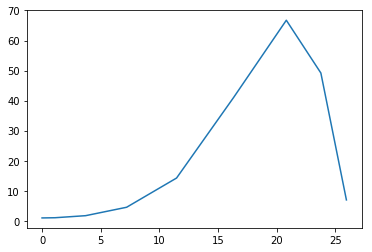

In [6]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.plot(f0Sol.t, f0Sol.y[0])
plt.show()

It looks like the correct solution but very few points. Let's try playing with `rtol` option.

In [7]:
f0SolrE5 = solve_ivp(f0RHS, [0, float(param[3])], f0BC, rtol = 1e-5, atol = 1e-10)
f0SolrE5.success

True

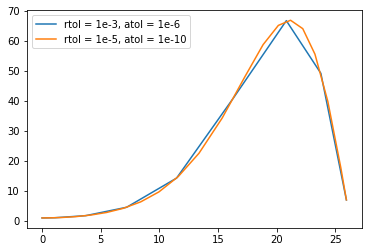

In [8]:
plt.plot(f0Sol.t, f0Sol.y[0], label='rtol = 1e-3, atol = 1e-6')
plt.plot(f0SolrE5.t, f0SolrE5.y[0], label='rtol = 1e-5, atol = 1e-10')
plt.legend()
plt.show()

Seems working. Let's add one more

In [9]:
f0SolrE8 = solve_ivp(f0RHS, [0, float(param[3])], f0BC, rtol = 1e-8, atol=1e-16)
f0SolrE8.success

True

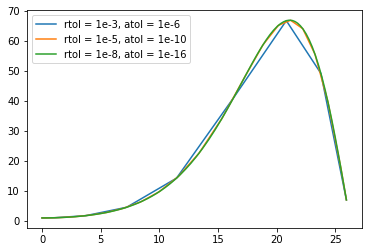

In [10]:
plt.plot(f0Sol.t, f0Sol.y[0], label='rtol = 1e-3, atol = 1e-6')
plt.plot(f0SolrE5.t, f0SolrE5.y[0], label='rtol = 1e-5, atol = 1e-10')
plt.plot(f0SolrE8.t, f0SolrE8.y[0], label='rtol = 1e-8, atol = 1e-16')
plt.legend()
plt.show()

Let's check the values on the boundary.

In [11]:
print(f0Sol.y[0][-1],f0SolrE5.y[0][-1],f0SolrE8.y[0][-1])

6.988315004953613 7.017038295371648 7.017154260072229


The value computed with `Mathematica` is $7.0171542411630329642075794582046527517$.

In [12]:
7.0171542411630329642075794582046527517 - f0SolrE8.y[0][-1]

-1.8909195986793748e-08

The agreement lies within the tolerance given by `rtol`.

Let's check the number of mesh points.

In [13]:
print(len(f0Sol.t),len(f0SolrE5.t),len(f0SolrE8.t))

11 25 88


Finally calculate the $\tilde{h}^2$

In [14]:
print(f0Sol.y[1][-1],f0SolrE5.y[1][-1],f0SolrE8.y[1][-1])

-22.866761622279547 -22.834248245184394 -22.834105196831615


In [16]:
f0IR = f0SolrE8.y[0][-1]
f0pIR = f0SolrE8.y[1][-1]
h0sq = (float(param[8])/2. - (2 + f0pIR/f0IR)*(1./float(param[6])))*(1./(f0IR**2))
print(h0sq)

0.0006564761873934516


`Mathematica` result is $0.00065647560106172245582415781579615580$.

In [17]:
0.00065647560106172245582415781579615580 - h0sq

-5.863317291540313e-10

Again agrees within the tolerance. 

# Solving BVP

Now we return to solving our BVP

$$
\phi''(y)-4\phi'(y)-\epsilon(\epsilon - 4)\phi(y) + \lambda \tilde{h}^2 e^{4(y-y_1)}f^2(y) = 0\\
f''(y) - (4 + m_h^2 -\lambda \phi(y))f(y) = 0
$$

with boundary conditions

$$
\phi(0) = v_0, \quad \phi(y_1) = v_1, \quad f'(0) = \left(\frac{M_0^2}{2}-2\right)f(0),\quad 2 + \frac{f'(y_1)}{f(y_1)}=-\lambda_h \left(\tilde{h}^2 f^2(y_1) - \frac{v_h^2}{2}\right)
$$

We do still have an unknown parameter $\tilde{h}$. Fortunately we can setup `solve_bvp` to find this unknown parameter too. We just need an additional boundary condition which we will take as before $f(0)=1$. 

Again we need to convert this 2nd order system to a first order system. Defining $\vec{F} = (\phi, \phi',f,f')$ yields

$$
F'_0 = F_1 \\
F'_1 = 4 F_1 + \epsilon(\epsilon -4)F_0 -\lambda \tilde{h}^2 e^{4(y-y_1)}F_2^2 \\
F_2' = F_3 \\
F_3' = (4 + m_h^2 - \lambda F_0)F_2
$$

with boundary conditions

$$
F_0(0) - v_0 = 0 \\
F_0(y_1) - v_1 = 0 \\
F_2(0) - 1 = 0 \\
F_3(0) - \left(\frac{m_0^2}{2}-2\right) F_2(0) =0\\
F_3(y_1) + 2 F_2(y_1) + \lambda_h \left(\tilde{h}^2 (F_2(y_1))^2 - \frac{v_h^2}{2}\right)F_2(y_1)=0
$$

First we implement the RHS.

In [18]:
def fRHS(y, F, p):
    hsq = p[0]
    mhsq, lambdaGW = list(map(float, param[4:6]))
    epsilon = float(param[2])
    y1 = float(param[3])
    return np.vstack((F[1], 4*F[1] + epsilon*(epsilon - 4)*F[0] - lambdaGW*hsq*np.exp(4*(y-y1))*(F[2]**2), F[3], (4 + mhsq - lambdaGW*F[0])*F[2]))

Create the mesh at which our guess was calculated

In [19]:
yMesh = f0SolrE8.t

In order to calculate the background solution at points given by `yMesh`, we need to `vectorize` the functions which give the background solution and derivative for GW.

In [20]:
GW0_v = np.vectorize(GW0)
GW0Der_v = np.vectorize(GW0Der)

In [ ]:
Finally calculate the guess, 

In [22]:
FGuess = np.zeros((4,yMesh.size)) # Array which will hold our guess
FGuess[0] = GW0_v(yMesh) # Guess for \phi(y)
FGuess[1] = GW0Der_v(yMesh) # Guess for \phi'(y)
FGuess[2] = f0SolrE8.y[0] # Guess for f(y)
FGuess[3] = f0SolrE8.y[1] # Guess for f'(y)

Next we implement the boundary conditions

In [23]:
def fBC(Fa, Fb, p):
    v0, v1 = list(map(float, param[0:2]))
    lambdaH, m0sq, vsq = list(map(float, param[6:9]))
    hsq = p[0]
    return np.array([Fa[0] - v0, Fa[2] - 1, Fa[3] - (m0sq/2 - 2)*Fa[2], Fb[0] - v1, Fb[3] + 2*Fb[2] + lambdaH*(hsq*(Fb[2]**2)-(vsq/2))*Fb[2]])   

In [25]:
fBC([0.1, 0, 1.0, 0], [1.0, 0, f0IR, f0pIR], [h0sq])

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.77635684e-15])

We have everything for the minimal run `solve_bvp(fun, bc, x, y, p)`. Let's give it a try

In [26]:
from scipy.integrate import solve_bvp

fBVPTry1 = solve_bvp(fRHS, fBC, yMesh, FGuess, [h0sq])
fBVPTry1.success

True

It says it converged to required accuracy. We need to plot though, before celebrating. 

In [28]:
yPlotMesh = np.linspace(0, float(param[3]), 200) # Mesh for plotting
fPlotsTry1 = fBVPTry1.sol(yPlotMesh) # Calculate the values of the solution as points specified by yPlotMesh

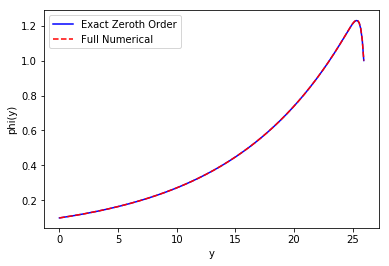

In [31]:
plt.plot(yPlotMesh, GW0_v(yPlotMesh),'b-', label='Exact Zeroth Order')
plt.plot(yPlotMesh, fPlotsTry1[0],'r--', label='Full Numerical')
plt.xlabel('y')
plt.ylabel('phi(y)')
plt.legend()
plt.show()

Is there a difference?

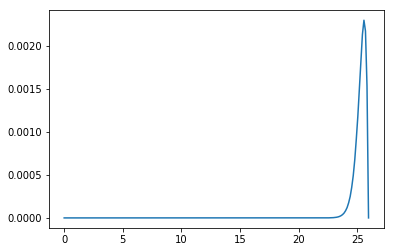

In [32]:
plt.plot(yPlotMesh, fPlotsTry1[0] - list(map(float,GW0_v(yPlotMesh))))
plt.show()

Yes there is! We can zoom in. 

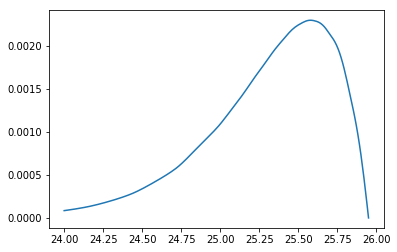

In [33]:
yPlotMeshZoom = np.linspace(24, float(param[3]), 200) # Mesh for plotting
fPlotsTry1Zoom = fBVPTry1.sol(yPlotMeshZoom) # Calculate the values of the solution as points specified by yPlotMesh
plt.plot(yPlotMeshZoom, fPlotsTry1Zoom[0] - list(map(float,GW0_v(yPlotMeshZoom))))
plt.show()

Let's plot everything. 

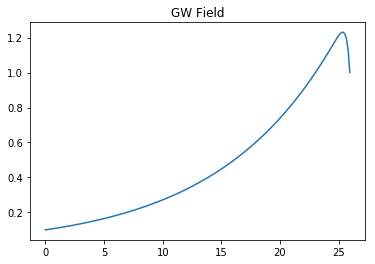

In [44]:
plt.plot(yPlotMesh, fPlotsTry1[0])
plt.title('GW Field')

plt.show()

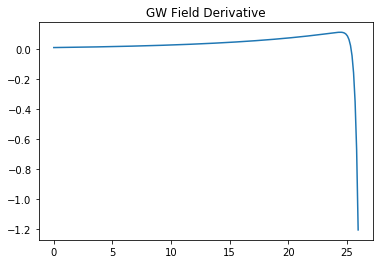

In [45]:
plt.plot(yPlotMesh, fPlotsTry1[1])
plt.title('GW Field Derivative')

plt.show()

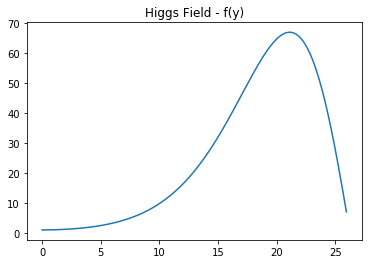

In [46]:
plt.plot(yPlotMesh, fPlotsTry1[2])
plt.title('Higgs Field - f(y)')

plt.show()

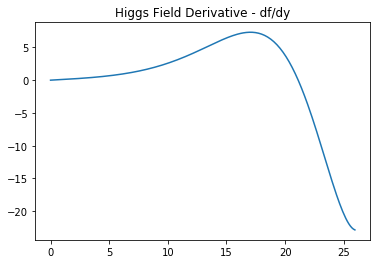

In [47]:
plt.plot(yPlotMesh, fPlotsTry1[3])
plt.title('Higgs Field Derivative - df/dy')

plt.show()

Calculate the ratio of the numerical and zeroth order exact GW solution 

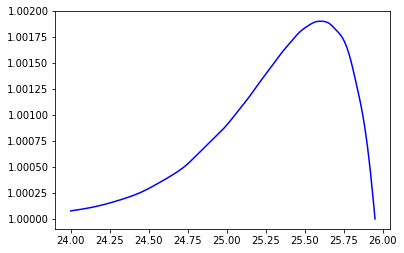

In [52]:
GWratio = []

for i in range(len(yPlotMeshZoom)):
    GWratio.append(fPlotsTry1Zoom[0][i]/float(GW0(yPlotMeshZoom[i])))
    

plt.plot(yPlotMeshZoom, GWratio , 'b-')
plt.show()